In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.diagnostic as smd
from sklearn.preprocessing import PowerTransformer
from pykalman import KalmanFilter

In [2]:
df = pd.read_excel("Econ 440 March 2025 data sets Revised.xlsx")
df = df.iloc[2:]
df['Date'] = pd.to_datetime(df['Date'])
df.drop(df.tail(3).index,inplace=True)
uncertainty = df[['Date', 'Uncertainty JLN 1 year ahead']].dropna()
uncertainty.drop(uncertainty[uncertainty.Date > "10/01/2024"].index, inplace=True)
uncertainty.set_index('Date', inplace=True)
print(uncertainty.isna().sum())
uncertainty

Uncertainty JLN 1 year ahead    0
dtype: int64


,Uncertainty JLN 1 year ahead
Date,
1960-07-01,0.73539
1960-08-01,0.739704
1960-09-01,0.745898
1960-10-01,0.756852
1960-11-01,0.779458
...,...
2024-06-01,0.76261
2024-07-01,0.758789
2024-08-01,0.756903


In [3]:
df1 = pd.read_excel('baatr(1).xlsx')
df1['date'] = pd.to_datetime(df1['date'], format='%m/%d/%Y')
df1 = df1[(df1['date'] >= "1960-07-01") & (df1['date'] <= "2024-10-01")]
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('date')
mask = (df1.index >= '2020-05-01') & (df1.index <= '2020-12-01')
df1.loc[mask, 'pccf '] = 1
df1


,TR10,Baa,pccf,pccfshift
date,,,,
1960-07-01,3.90,5.22,0,0
1960-08-01,3.80,5.08,0,0
1960-09-01,3.80,5.01,0,0
1960-10-01,3.89,5.11,0,0
1960-11-01,3.93,5.08,0,0
...,...,...,...,...
2024-06-01,4.31,5.82,0,1
2024-07-01,4.25,5.84,0,1
2024-08-01,3.87,5.60,0,1


In [4]:
df1['Uncertainty'] = uncertainty.values.tolist()
df1['Uncertainty'] = df1['Uncertainty'].apply(lambda x: float(x[0]))
print(df1.isna().sum())

TR10           0
Baa            0
pccf           0
pccfshift      0
Uncertainty    0
dtype: int64


In [5]:
# Extract quarter information
df1['Date'] = df1.index

# Extract quarter information using dt.to_period('Q')
df1['quarter'] = df1.index.to_period('Q')

# Resample to quarterly data, using mean (or any other aggregation function)
df1_quarterly = df1.resample('QE').mean()

df1_quarterly

,TR10,Baa,pccf,pccfshift,Uncertainty,Date,quarter
date,,,,,,,
1960-09-30,3.833333,5.103333,0.0,0.0,0.740330,1960-08-01 00:00:00,1960Q3
1960-12-31,3.886667,5.096667,0.0,0.0,0.777282,1960-10-31 16:00:00,1960Q4
1961-03-31,3.786667,5.063334,0.0,0.0,0.791845,1961-01-31 00:00:00,1961Q1
1961-06-30,3.790000,5.016667,0.0,0.0,0.777518,1961-05-01 08:00:00,1961Q2
1961-09-30,3.980000,5.106667,0.0,0.0,0.754342,1961-08-01 00:00:00,1961Q3
...,...,...,...,...,...,...,...
2023-12-31,4.440000,6.186667,0.0,1.0,0.812445,2023-10-31 16:00:00,2023Q4
2024-03-31,4.160000,5.733333,0.0,1.0,0.796828,2024-01-31 08:00:00,2024Q1
2024-06-30,4.443333,5.923333,0.0,1.0,0.769911,2024-05-01 08:00:00,2024Q2


In [6]:
df2 = pd.read_csv("GDPC1_GDPPOT.csv")
df2 = df2.set_index("observation_date")
df2

,GDPC1_GDPPOT
observation_date,
1960-07-01,-1.388574
1960-10-01,-3.578951
1961-01-01,-3.825748
1961-04-01,-3.038207
1961-07-01,-2.052768
...,...
2023-10-01,1.648718
2024-01-01,1.476420
2024-04-01,1.636928


In [7]:
df1_quarterly = df1_quarterly.set_index(df2.index)
df1_quarterly['Output_Gap'] = df2['GDPC1_GDPPOT']
df1_quarterly = df1_quarterly.rename(columns=lambda x: x.strip())
df1_quarterly.set_index('quarter', inplace=True)
df1_quarterly = df1_quarterly.drop('Date', axis=1)
df1_quarterly['Corp_Spread'] = df1_quarterly['Baa'] - df1_quarterly['TR10']
df1_quarterly['pccf:Output_Gap'] = df1_quarterly['pccf'] * df1_quarterly['Output_Gap']
df1_quarterly['pccf:Uncertainty'] = df1_quarterly['pccf'] * df1_quarterly['Uncertainty']
df1_quarterly


,TR10,Baa,pccf,pccfshift,Uncertainty,Output_Gap,Corp_Spread,pccf:Output_Gap,pccf:Uncertainty
quarter,,,,,,,,,
1960Q3,3.833333,5.103333,0.0,0.0,0.740330,-1.388574,1.270000,-0.0,0.0
1960Q4,3.886667,5.096667,0.0,0.0,0.777282,-3.578951,1.210000,-0.0,0.0
1961Q1,3.786667,5.063334,0.0,0.0,0.791845,-3.825748,1.276667,-0.0,0.0
1961Q2,3.790000,5.016667,0.0,0.0,0.777518,-3.038207,1.226667,-0.0,0.0
1961Q3,3.980000,5.106667,0.0,0.0,0.754342,-2.052768,1.126667,-0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023Q4,4.440000,6.186667,0.0,1.0,0.812445,1.648718,1.746667,0.0,0.0
2024Q1,4.160000,5.733333,0.0,1.0,0.796828,1.476420,1.573333,0.0,0.0
2024Q2,4.443333,5.923333,0.0,1.0,0.769911,1.636928,1.480000,0.0,0.0


In [8]:
df1_quarterly.describe()

,TR10,Baa,pccf,pccfshift,Uncertainty,Output_Gap,Corp_Spread,pccf:Output_Gap,pccf:Uncertainty
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,5.801132,7.824447,0.010336,0.072351,0.790506,-0.401276,2.023314,-0.040572,0.011550
std,2.935436,2.918730,0.096975,0.257901,0.107232,2.213562,0.766913,0.424757,0.107366
min,0.650000,3.236667,0.000000,0.000000,0.654613,-9.126211,0.394012,-6.084141,0.000000
25%,3.863715,5.370102,0.000000,0.000000,0.721347,-1.659885,1.514525,0.000000,0.000000
50%,5.499917,7.611596,0.000000,0.000000,0.760309,-0.303800,1.958333,-0.000000,0.000000
75%,7.526543,9.369167,0.000000,0.000000,0.813653,1.094102,2.501482,-0.000000,0.000000
max,14.847287,17.033335,1.000000,1.000000,1.284492,5.683811,5.587273,0.000000,1.128017


In [9]:
# Prepare the design matrix (excluding the dependent variable)
X = df1_quarterly[['Output_Gap', 'Uncertainty', 'pccf', 'pccfshift']]
X['pccf:Output_Gap'] = df1_quarterly['pccf'] * df1_quarterly['Output_Gap']
X['pccf:Uncertainty'] = df1_quarterly['pccf'] * df1_quarterly['Uncertainty']

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


            feature         VIF
0        Output_Gap    1.152000
1       Uncertainty    1.172423
2              pccf  372.872317
3         pccfshift    1.285857
4   pccf:Output_Gap   11.203294
5  pccf:Uncertainty  467.660708


C:\Users\buitu\AppData\Local\Temp\ipykernel_29572\1200855255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pccf:Output_Gap'] = df1_quarterly['pccf'] * df1_quarterly['Output_Gap']
C:\Users\buitu\AppData\Local\Temp\ipykernel_29572\1200855255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pccf:Uncertainty'] = df1_quarterly['pccf'] * df1_quarterly['Uncertainty']


In [10]:
# Compute skewness
skewness = df1_quarterly.skew()
print(skewness)

# Identify features that are highly skewed (e.g., |skewness| > 1)
skewed_features = skewness[skewness > 1].index
print("Features suitable for Yeo-Johnson transformation:", list(skewed_features))

TR10                 0.748160
Baa                  0.945191
pccf                 9.550481
pccfshift            3.312089
Uncertainty          1.665787
Output_Gap          -0.356390
Corp_Spread          0.854055
pccf:Output_Gap    -12.368953
pccf:Uncertainty     9.337782
dtype: float64
Features suitable for Yeo-Johnson transformation: ['pccf', 'pccfshift', 'Uncertainty', 'pccf:Uncertainty']


In [11]:
lambda_values = {}
pt = PowerTransformer(method='yeo-johnson', standardize=True)
for col in ['Uncertainty', 'pccf', 'pccfshift', 'pccf:Uncertainty', 'pccf:Output_Gap']:
    new_col = f'yj_{col.replace(":", "_")}'
    df1_quarterly[new_col] = pt.fit_transform(df1_quarterly[[col]])
    lambda_values[col] = pt.lambdas_[0]
    
for var, lam in lambda_values.items():
    print(f"Lambda for {var}: {lam:.4f}")

Lambda for Uncertainty: -10.0256
Lambda for pccf: -135.9956
Lambda for pccfshift: -19.8646
Lambda for pccf:Uncertainty: -124.9548
Lambda for pccf:Output_Gap: 62.4121


In [12]:
features = ['yj_pccf', 'yj_pccf_Output_Gap', 'yj_pccf_Uncertainty']
X_features = df1_quarterly[features].values

# Define the Kalman Filter
kf = KalmanFilter(initial_state_mean=np.mean(X_features, axis=0),
                  n_dim_obs=X_features.shape[1], 
                  transition_matrices=np.eye(X_features.shape[1]),  # Identity matrix (no transformation)
                  observation_matrices=np.eye(X_features.shape[1]),  # Direct observation
                  observation_covariance=np.cov(X_features.T),  # Estimate covariance from data
                  transition_covariance=np.eye(X_features.shape[1]) * 0.01)  # Small process noise

# Apply Kalman Filter smoothing
filtered_state_means, _ = kf.filter(X_features)

# Replace original features with the filtered versions
df1_quarterly[features] = filtered_state_means
df1_quarterly.describe()

,TR10,Baa,pccf,pccfshift,Uncertainty,Output_Gap,Corp_Spread,pccf:Output_Gap,pccf:Uncertainty,yj_Uncertainty,yj_pccf,yj_pccfshift,yj_pccf_Uncertainty,yj_pccf_Output_Gap
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,2.580000e+02,258.000000,2.580000e+02,258.000000,258.000000
mean,5.801132,7.824447,0.010336,0.072351,0.790506,-0.401276,2.023314,-0.040572,0.011550,-9.421576e-14,-0.035547,-2.754042e-17,-0.035547,0.035547
std,2.935436,2.918730,0.096975,0.257901,0.107232,2.213562,0.766913,0.424757,0.107366,1.001944e+00,0.259147,1.001944e+00,0.259147,0.259147
min,0.650000,3.236667,0.000000,0.000000,0.654613,-9.126211,0.394012,-6.084141,0.000000,-2.180770e+00,-0.108465,-2.819537e-01,-0.108465,-1.372190
25%,3.863715,5.370102,0.000000,0.000000,0.721347,-1.659885,1.514525,0.000000,0.000000,-6.828447e-01,-0.108464,-2.819537e-01,-0.108464,0.106213
50%,5.499917,7.611596,0.000000,0.000000,0.760309,-0.303800,1.958333,-0.000000,0.000000,-6.395670e-02,-0.108410,-2.819537e-01,-0.108410,0.108410
75%,7.526543,9.369167,0.000000,0.000000,0.813653,1.094102,2.501482,-0.000000,0.000000,5.723943e-01,-0.106213,-2.819537e-01,-0.106213,0.108464
max,14.847287,17.033335,1.000000,1.000000,1.284492,5.683811,5.587273,0.000000,1.128017,2.215893e+00,1.372190,3.546689e+00,1.372190,0.108465


In [13]:
df1_quarterly['CFMA'] = (df1_quarterly.index > pd.Period('2000Q4')).astype(int)
df1_quarterly

,TR10,Baa,pccf,pccfshift,Uncertainty,Output_Gap,Corp_Spread,pccf:Output_Gap,pccf:Uncertainty,yj_Uncertainty,yj_pccf,yj_pccfshift,yj_pccf_Uncertainty,yj_pccf_Output_Gap,CFMA
quarter,,,,,,,,,,,,,,,
1960Q3,3.833333,5.103333,0.0,0.0,0.740330,-1.388574,1.270000,-0.0,0.0,-0.362228,-0.027037,-0.281954,-0.027037,0.027037,0
1960Q4,3.886667,5.096667,0.0,0.0,0.777282,-3.578951,1.210000,-0.0,0.0,0.161699,-0.043458,-0.281954,-0.043458,0.043458,0
1961Q1,3.786667,5.063334,0.0,0.0,0.791845,-3.825748,1.276667,-0.0,0.0,0.337236,-0.054516,-0.281954,-0.054516,0.054516,0
1961Q2,3.790000,5.016667,0.0,0.0,0.777518,-3.038207,1.226667,-0.0,0.0,0.164670,-0.062490,-0.281954,-0.062490,0.062490,0
1961Q3,3.980000,5.106667,0.0,0.0,0.754342,-2.052768,1.126667,-0.0,0.0,-0.149150,-0.068525,-0.281954,-0.068525,0.068525,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q4,4.440000,6.186667,0.0,1.0,0.812445,1.648718,1.746667,0.0,0.0,0.560182,0.633171,3.546689,0.633171,-0.633171,1
2024Q1,4.160000,5.733333,0.0,1.0,0.796828,1.476420,1.573333,0.0,0.0,0.393766,0.591649,3.546689,0.591649,-0.591649,1
2024Q2,4.443333,5.923333,0.0,1.0,0.769911,1.636928,1.480000,0.0,0.0,0.066624,0.552452,3.546689,0.552452,-0.552452,1


In [14]:
model_formula = ('Corp_Spread ~ Output_Gap + yj_Uncertainty + yj_pccf + '
                 'yj_pccfshift + CFMA + yj_pccf_Output_Gap + yj_pccf_Uncertainty')

# Fit the initial OLS model with HC0 standard errors
model = smf.ols(model_formula, data=df1_quarterly).fit(cov_type='HC0')

# Compute weights as the inverse square of fitted values
weights = 1 / model.fittedvalues**2

# Fit the Weighted Least Squares model using the same formula and weights
model_wls = smf.wls(model_formula, data=df1_quarterly, weights=weights).fit(cov_type='HC0')
print(model_wls.summary())

                            WLS Regression Results                            
Dep. Variable:            Corp_Spread   R-squared:                       0.659
Model:                            WLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     106.4
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.93e-60
Time:                        22:04:25   Log-Likelihood:                -170.87
No. Observations:                 258   AIC:                             353.7
Df Residuals:                     252   BIC:                             375.1
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.7186    

C:\Users\buitu\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [15]:
print(smd.het_breuschpagan(model_wls.resid, model_wls.model.exog))


(21.83773608598377, 0.0027092763186527757, 4.660447780659424, 0.0004358840088759231)


In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

wls_predictions = model_wls.fittedvalues

# Feature matrix and target
features = ['Output_Gap', 'yj_Uncertainty', 'yj_pccf_Output_Gap', 'yj_pccf_Uncertainty']
X_features = df1_quarterly[features].values
X_wls_pred = wls_predictions.values.reshape(-1, 1)

X_full = np.hstack([X_features, X_wls_pred])
y = df1_quarterly['Corp_Spread'].values

# Sample weights from WLS model
wls_weights = model_wls.model.weights

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_full, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
weights_tensor = torch.tensor(wls_weights, dtype=torch.float32)

# --- Custom Dataset ---
class FinancialDataset(Dataset):
    def __init__(self, X, y, weights):
        self.X = X
        self.y = y
        self.weights = weights

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

# Create train and validation datasets
dataset = FinancialDataset(X_tensor, y_tensor, weights_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Define Neural Network ---
class ComplexNN(nn.Module):
    def __init__(self, input_dim):
        super(ComplexNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 1)  # Output layer (regression)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
input_dim = X_full.shape[1]
model = ComplexNN(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function (weighted Huber loss) and optimizer
criterion = nn.HuberLoss(reduction='none')  # We'll apply weights manually
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# --- Training Loop ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs= 100, patience= 5):
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y, batch_weights in train_loader:
            batch_X, batch_y, batch_weights = batch_X.to(device), batch_y.to(device), batch_weights.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss_unweighted = criterion(outputs, batch_y)  # Compute loss per sample
            loss_weighted = (loss_unweighted * batch_weights.view(-1, 1)).mean()  # Apply weights and take mean
            loss_weighted.backward()
            optimizer.step()
            
            total_loss += loss_weighted.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y, batch_weights in val_loader:
                batch_X, batch_y, batch_weights = batch_X.to(device), batch_y.to(device), batch_weights.to(device)
                outputs = model(batch_X)
                loss_unweighted = criterion(outputs, batch_y)
                loss_weighted = (loss_unweighted * batch_weights.view(-1, 1)).mean()
                val_loss += loss_weighted.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        scheduler.step(val_loss)
        
        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience= 100)

# --- Evaluate Model ---
model.eval()
with torch.no_grad():
    # Ensure the entire dataset tensors are on the device
    X_tensor_device = X_tensor.to(device)
    y_tensor_device = y_tensor.to(device)
    weights_tensor_device = weights_tensor.to(device)
    
    predictions = model(X_tensor_device)
    final_loss_unweighted = criterion(predictions, y_tensor_device)  # Compute loss per sample
    final_loss_weighted = (final_loss_unweighted * weights_tensor_device.view(-1, 1)).mean()  # Apply weights and then take the mean
    print(f"Final Model Loss: {final_loss_weighted.item():.4f}")


Epoch 1, Train Loss: 0.3216, Val Loss: 0.3502
Epoch 2, Train Loss: 0.3189, Val Loss: 0.2891
Epoch 3, Train Loss: 0.3121, Val Loss: 0.2354
Epoch 4, Train Loss: 0.2792, Val Loss: 0.1973
Epoch 5, Train Loss: 0.2661, Val Loss: 0.1889
Epoch 6, Train Loss: 0.2484, Val Loss: 0.1849
Epoch 7, Train Loss: 0.2416, Val Loss: 0.2056
Epoch 8, Train Loss: 0.2276, Val Loss: 0.1588
Epoch 9, Train Loss: 0.2234, Val Loss: 0.1542
Epoch 10, Train Loss: 0.2064, Val Loss: 0.1308
Epoch 11, Train Loss: 0.2090, Val Loss: 0.1187
Epoch 12, Train Loss: 0.1929, Val Loss: 0.1375
Epoch 13, Train Loss: 0.2006, Val Loss: 0.1592
Epoch 14, Train Loss: 0.1925, Val Loss: 0.1289
Epoch 15, Train Loss: 0.1945, Val Loss: 0.1190
Epoch 16, Train Loss: 0.1773, Val Loss: 0.1153
Epoch 17, Train Loss: 0.1706, Val Loss: 0.1154
Epoch 18, Train Loss: 0.1773, Val Loss: 0.1065
Epoch 19, Train Loss: 0.1875, Val Loss: 0.1222
Epoch 20, Train Loss: 0.1674, Val Loss: 0.1207
Epoch 21, Train Loss: 0.1629, Val Loss: 0.1144
Epoch 22, Train Loss: 

In [17]:
from torchsummary import summary

# Assuming `model` is already instantiated and moved to the proper device.
# Define the input shape. For a fully connected network, the input is a 1D tensor.
# For example, if your input has 'input_dim' features:
input_size = (input_dim,)  # Tuple representing the shape of one sample

# Print the summary of the model
summary(model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             768
              ReLU-2                  [-1, 128]               0
       BatchNorm1d-3                  [-1, 128]             256
           Dropout-4                  [-1, 128]               0
            Linear-5                  [-1, 256]          33,024
              ReLU-6                  [-1, 256]               0
       BatchNorm1d-7                  [-1, 256]             512
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 256]          65,792
             ReLU-10                  [-1, 256]               0
      BatchNorm1d-11                  [-1, 256]             512
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

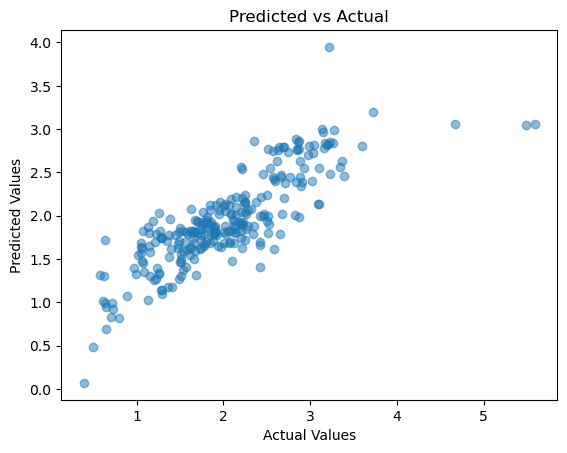

In [18]:
# Make predictions on the entire dataset
model.eval()
with torch.no_grad():
    predictions = model(X_tensor.to(device))

# Convert predictions to CPU and NumPy
predictions = predictions.cpu().numpy()
y_actual = y_tensor.cpu().numpy()

# Plot predictions vs actual values
plt.scatter(y_actual, predictions, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_actual, predictions, squared=False)
print(f"RMSE: {rmse:.4f}")


RMSE: 0.4424


C:\Users\buitu\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


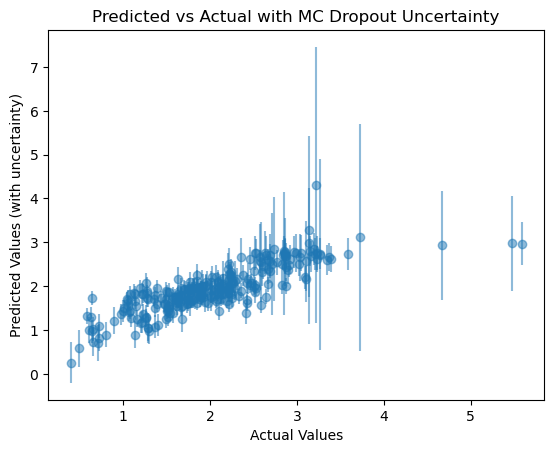

In [20]:
model.train()  # keep dropout active during inference
n_samples = 100
predictions_samples = []

with torch.no_grad():
    for _ in range(n_samples):
        preds = model(X_tensor.to(device))
        predictions_samples.append(preds.cpu().numpy())

predictions_samples = np.array(predictions_samples)

# Compute mean and standard deviation for each data point and flatten them
pred_mean = predictions_samples.mean(axis=0).ravel()
pred_std = predictions_samples.std(axis=0).ravel()
y_actual_flat = y_actual.ravel()

# Now, plot using flattened arrays
plt.errorbar(y_actual_flat, pred_mean, yerr=pred_std, fmt='o', alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values (with uncertainty)")
plt.title("Predicted vs Actual with MC Dropout Uncertainty")
plt.show()


In [21]:
from sklearn.metrics import r2_score

r_square = r2_score(y_actual, predictions)
print(f"R^2: {r_square:.4f}")


R^2: 0.6659


In [22]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_actual, predictions)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.4424


In [23]:
def permutation_feature_importance(model, X, y, weights, metric_fn, n_repeats=20):
    baseline_preds = model(X).detach()
    baseline_loss = metric_fn(baseline_preds, y)
    baseline_loss = (baseline_loss * weights.view(-1, 1)).mean().item()

    importances = []

    for col in range(X.shape[1]):
        loss_diffs = []
        for _ in range(n_repeats):
            X_perm = X.clone()
            X_perm[:, col] = X_perm[:, col][torch.randperm(X_perm.size(0))]  # Shuffle feature
            preds = model(X_perm).detach()
            loss = metric_fn(preds, y)
            loss = (loss * weights.view(-1, 1)).mean().item()
            loss_diffs.append(loss - baseline_loss)
        importances.append(np.mean(loss_diffs))

    return np.array(importances)

importances = permutation_feature_importance(model, X_tensor_device, y_tensor_device, weights_tensor_device, criterion)
for i, f in enumerate(features + ['WLS_Pred']):
    print(f"{f}: {importances[i]:.4f}")


Output_Gap: 0.0371
yj_Uncertainty: 0.0119
yj_pccf_Output_Gap: -0.0001
yj_pccf_Uncertainty: 0.0006
WLS_Pred: 0.0215


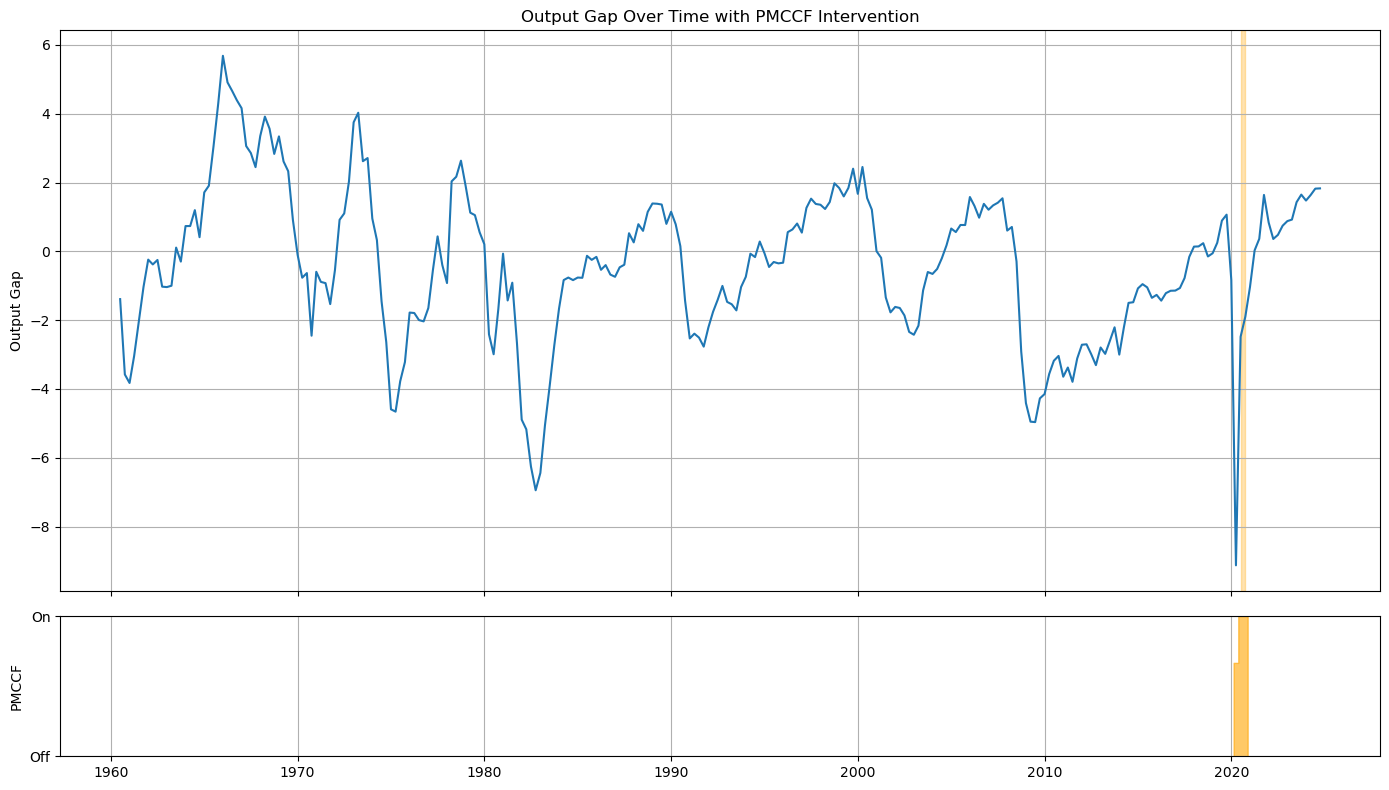

In [24]:
df_plot = df1_quarterly.copy()
if isinstance(df_plot.index, pd.PeriodIndex):
    df_plot.index = df_plot.index.to_timestamp()

# Identify continuous pccf blocks
df_plot['pccf_active'] = df_plot['pccf'] == 1
df_plot['block'] = (df_plot['pccf_active'] != df_plot['pccf_active'].shift()).cumsum()
active_blocks = df_plot[df_plot['pccf_active']].groupby('block')

# Add a secondary plot below showing when PMCCF is active
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# Main plot
sns.lineplot(x=df_plot.index, y='Output_Gap', data=df_plot, ax=ax[0])
ax[0].set_title("Output Gap Over Time with PMCCF Intervention")
ax[0].set_ylabel("Output Gap")
ax[0].grid(True)

# Shade periods
for _, block in active_blocks:
    start_date = block.index.min()
    end_date = block.index.max()
    ax[0].axvspan(start_date, end_date, color='orange', alpha=0.3)

# Secondary plot: PMCCF periods as bars
ax[1].fill_between(df_plot.index, 0, df_plot['pccf'], color='orange', step='mid', alpha=0.6)
ax[1].set_ylim(0, 1)
ax[1].set_yticks([0, 1])
ax[1].set_yticklabels(['Off', 'On'])
ax[1].set_ylabel("PMCCF")
ax[1].grid(True)

plt.tight_layout()
plt.show()


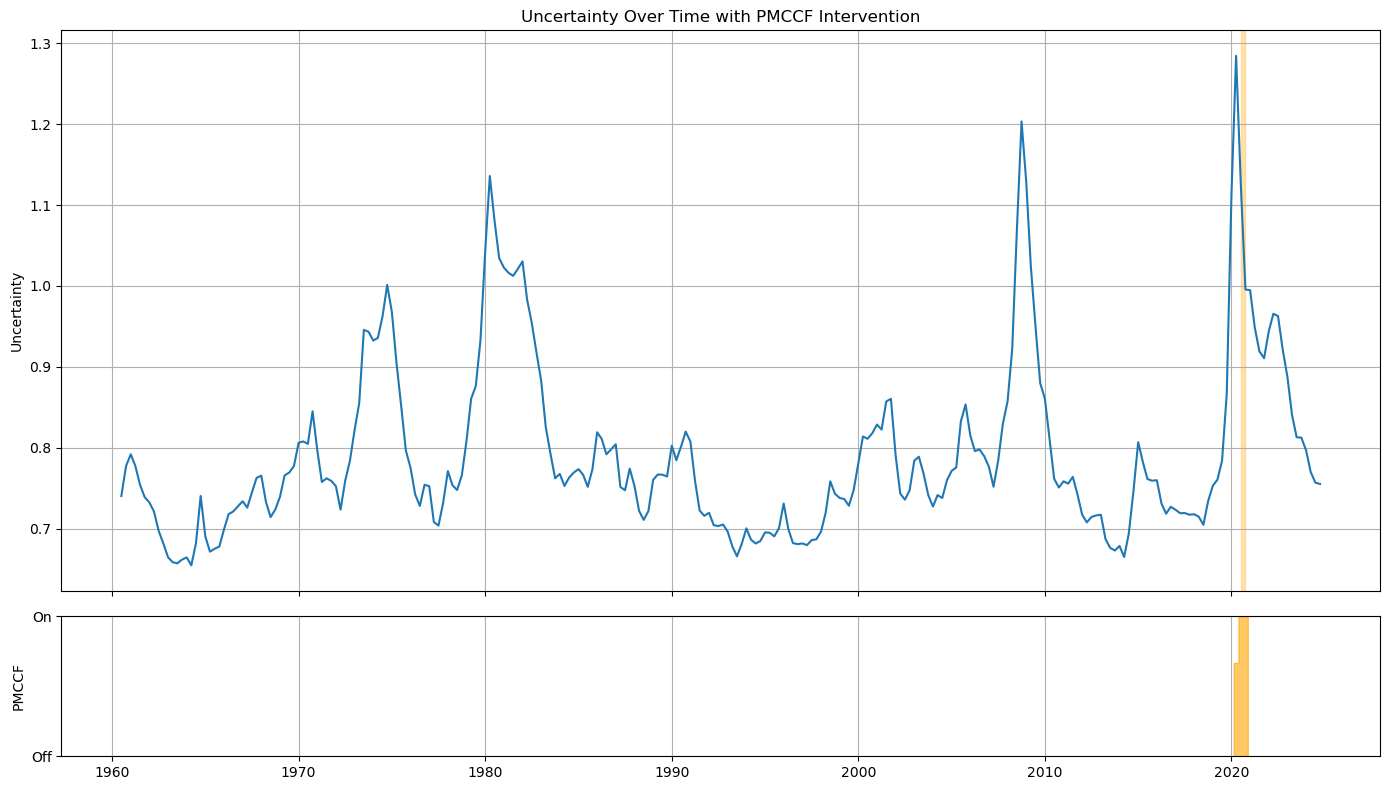

In [25]:
# Add a secondary plot below showing when PMCCF is active
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# Main plot
sns.lineplot(x=df_plot.index, y='Uncertainty', data=df_plot, ax=ax[0])
ax[0].set_title("Uncertainty Over Time with PMCCF Intervention")
ax[0].set_ylabel("Uncertainty")
ax[0].grid(True)

# Shade periods
for _, block in active_blocks:
    start_date = block.index.min()
    end_date = block.index.max()
    ax[0].axvspan(start_date, end_date, color='orange', alpha=0.3)

# Secondary plot: PMCCF periods as bars
ax[1].fill_between(df_plot.index, 0, df_plot['pccf'], color='orange', step='mid', alpha=0.6)
ax[1].set_ylim(0, 1)
ax[1].set_yticks([0, 1])
ax[1].set_yticklabels(['Off', 'On'])
ax[1].set_ylabel("PMCCF")
ax[1].grid(True)

plt.tight_layout()
plt.show()

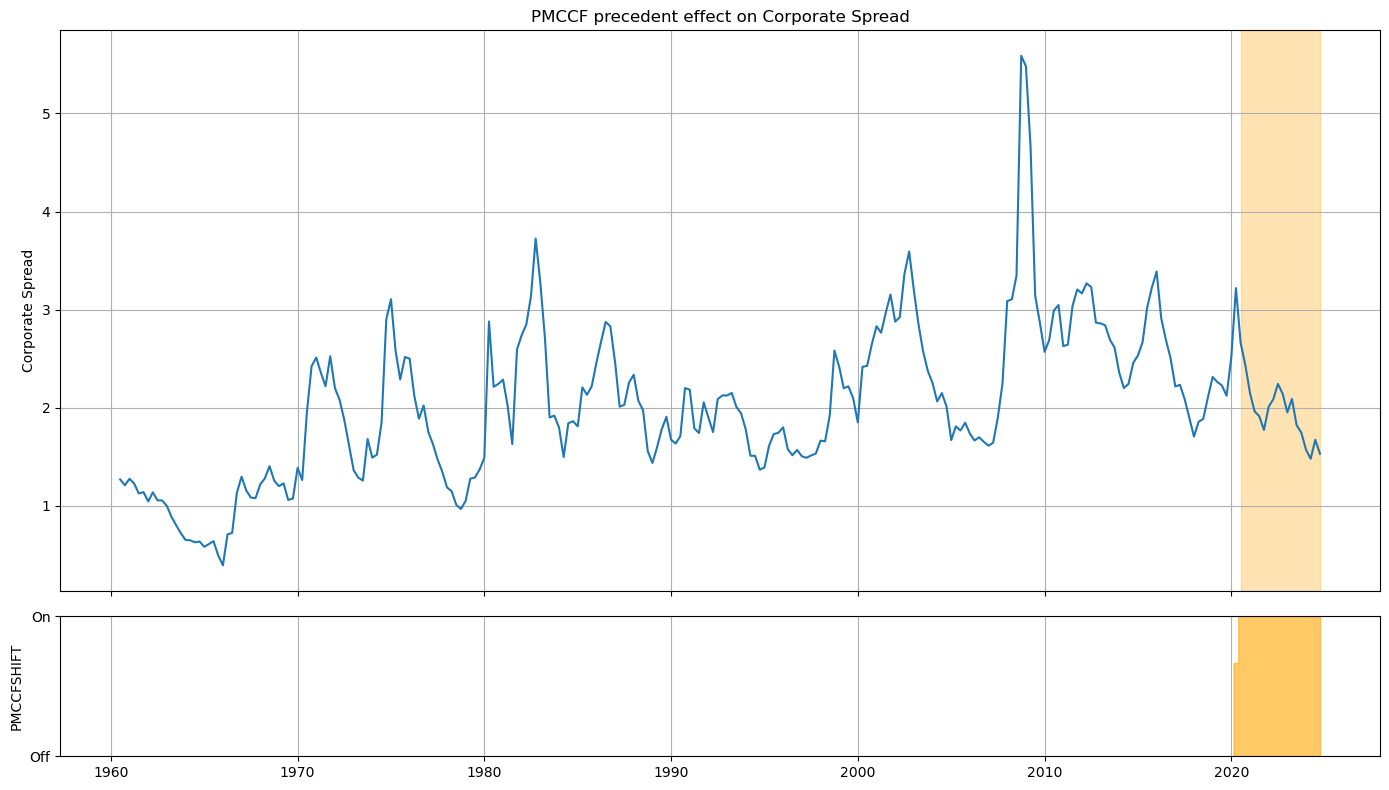

In [26]:
# Identify continuous pccfshift blocks
df_plot['pccfshift_active'] = df_plot['pccfshift'] == 1
df_plot['block'] = (df_plot['pccfshift_active'] != df_plot['pccfshift_active'].shift()).cumsum()
active_blocks = df_plot[df_plot['pccfshift_active']].groupby('block')

# Add a secondary plot below showing when PMCCF is active
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# Main plot
sns.lineplot(x=df_plot.index, y='Corp_Spread', data=df_plot, ax=ax[0])
ax[0].set_title("PMCCF precedent effect on Corporate Spread")
ax[0].set_ylabel("Corporate Spread")
ax[0].grid(True)

# Shade periods
for _, block in active_blocks:
    start_date = block.index.min()
    end_date = block.index.max()
    ax[0].axvspan(start_date, end_date, color='orange', alpha=0.3)

# Secondary plot: PMCCF periods as bars
ax[1].fill_between(df_plot.index, 0, df_plot['pccfshift'], color='orange', step='mid', alpha=0.6)
ax[1].set_ylim(0, 1)
ax[1].set_yticks([0, 1])
ax[1].set_yticklabels(['Off', 'On'])
ax[1].set_ylabel("PMCCFSHIFT")
ax[1].grid(True)

plt.tight_layout()
plt.savefig('pccfshift.png')
plt.show()

In [64]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# --- Data Setup ---
features = ['Output_Gap', 'yj_Uncertainty', 'yj_pccf_Output_Gap', 'yj_pccf_Uncertainty']
X_features = df1_quarterly[features].values
wls_predictions = model_wls.fittedvalues.values.reshape(-1, 1)
X_full = np.hstack([X_features, wls_predictions])
wls_weights = model_wls.model.weights
target_series = df1_quarterly['Corp_Spread'].values
dates = df1_quarterly.index

# --- Create y_future_array ---
horizon = 10
N = len(target_series) - horizon
y_future_array = np.stack([target_series[i+1:i+1+horizon] for i in range(N)])
X_full = X_full[:N]
wls_weights = wls_weights[:N]
future_base_dates = dates[:N]  # Starting point for each forecast

# --- Tensors ---
X_tensor = torch.tensor(X_full, dtype=torch.float32)
y_tensor = torch.tensor(y_future_array, dtype=torch.float32)
weights_tensor = torch.tensor(wls_weights, dtype=torch.float32)

# --- Dataset ---
class FinancialDataset(Dataset):
    def __init__(self, X, y, weights):
        self.X = X
        self.y = y
        self.weights = weights

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

dataset = FinancialDataset(X_tensor, y_tensor, weights_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Model ---
class ComplexNN(nn.Module):
    def __init__(self, input_dim, output_dim=10):
        super(ComplexNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, output_dim * 2)  # mean and log_std
        )

    def forward(self, x):
        return self.model(x)

# --- Gaussian NLL Loss ---
class GaussianNLLLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, output, target):
        mean = output[:, :10]
        log_std = output[:, 10:]
        std = torch.exp(log_std) + self.eps
        var = std ** 2
        nll = 0.5 * torch.log(2 * torch.pi * var) + (target - mean) ** 2 / (2 * var)
        return nll.mean(dim=1)

# --- Training Loop ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    best_loss = float('inf')
    patience_counter = 0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_X, batch_y, batch_weights in train_loader:
            batch_X, batch_y, batch_weights = batch_X.to(device), batch_y.to(device), batch_weights.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss_samplewise = criterion(output, batch_y)
            weighted_loss = (loss_samplewise * batch_weights).mean()
            weighted_loss.backward()
            optimizer.step()
            total_loss += weighted_loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y, batch_weights in val_loader:
                batch_X, batch_y, batch_weights = batch_X.to(device), batch_y.to(device), batch_weights.to(device)
                output = model(batch_X)
                loss_samplewise = criterion(output, batch_y)
                weighted_loss = (loss_samplewise * batch_weights).mean()
                val_loss += weighted_loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)

# --- Initialize and Train ---
input_dim = X_full.shape[1]
model = ComplexNN(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = GaussianNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

train_model(model, train_loader, val_loader, criterion, optimizer)

# --- Inference ---
model.eval()
with torch.no_grad():
    X_device = X_tensor.to(device)
    output = model(X_device)
    mean = output[:, :10]
    std = torch.exp(output[:, 10:])

    # Sample predictions
    dist = torch.distributions.Normal(mean, std)
    samples = dist.sample((1000,))  # [1000, N, 10]
    forecast_mean = samples.mean(dim=0).cpu().numpy()
    forecast_lower = samples.quantile(0.05, dim=0).cpu().numpy()
    forecast_upper = samples.quantile(0.95, dim=0).cpu().numpy()

Epoch 1, Train Loss: 2.0483, Val Loss: 0.8267
Epoch 2, Train Loss: 1.5076, Val Loss: 0.8403
Epoch 3, Train Loss: 1.5110, Val Loss: 0.8455
Epoch 4, Train Loss: 1.2972, Val Loss: 0.8618
Epoch 5, Train Loss: 1.1447, Val Loss: 0.8589
Epoch 6, Train Loss: 1.1715, Val Loss: 0.8408
Epoch 7, Train Loss: 0.9952, Val Loss: 0.8257
Epoch 8, Train Loss: 1.0159, Val Loss: 0.7891
Epoch 9, Train Loss: 0.9571, Val Loss: 0.7542
Epoch 10, Train Loss: 0.9521, Val Loss: 0.7399
Epoch 11, Train Loss: 0.9714, Val Loss: 0.7182
Epoch 12, Train Loss: 0.8485, Val Loss: 0.7019
Epoch 13, Train Loss: 0.9239, Val Loss: 0.6944
Epoch 14, Train Loss: 0.8370, Val Loss: 0.6702
Epoch 15, Train Loss: 0.8226, Val Loss: 0.6640
Epoch 16, Train Loss: 0.8225, Val Loss: 0.6458
Epoch 17, Train Loss: 0.7860, Val Loss: 0.6347
Epoch 18, Train Loss: 0.8029, Val Loss: 0.6285
Epoch 19, Train Loss: 0.7274, Val Loss: 0.6100
Epoch 20, Train Loss: 0.7873, Val Loss: 0.6078
Epoch 21, Train Loss: 0.7489, Val Loss: 0.6040
Epoch 22, Train Loss: 

In [68]:
import pandas as pd
import numpy as np

# Ensure y_future_array is already computed (shape: [n_samples, 10])
# Example: y_future_array = np.random.normal(1.5, 0.3, size=(5, 10))

# 1. Get the last known year in your dataset
last_known_year = df1_quarterly.index.max().year
forecast_years = list(range(last_known_year + 1, last_known_year + 11))  # 10 future years

# 2. Compute statistics
mean_forecast = y_future_array.mean(axis=0)
std_forecast = y_future_array.std(axis=0)
lower_95 = mean_forecast - 1.96 * std_forecast
upper_95 = mean_forecast + 1.96 * std_forecast

# 3. Assemble table
forecast_df = pd.DataFrame({
    "Year": forecast_years,
    "Mean_Predicted_Spread": mean_forecast,
    "Std_Dev": std_forecast,
    "95% CI Lower": lower_95,
    "95% CI Upper": upper_95
})

# 4. Display
print(forecast_df.round(4))


   Year  Mean_Predicted_Spread  Std_Dev  95% CI Lower  95% CI Upper
0  2025                 2.0352   0.7765        0.5132        3.5572
1  2026                 2.0390   0.7748        0.5204        3.5576
2  2027                 2.0417   0.7733        0.5260        3.5574
3  2028                 2.0452   0.7716        0.5329        3.5574
4  2029                 2.0480   0.7695        0.5398        3.5562
5  2030                 2.0504   0.7675        0.5460        3.5548
6  2031                 2.0526   0.7655        0.5522        3.5529
7  2032                 2.0539   0.7641        0.5562        3.5517
8  2033                 2.0564   0.7619        0.5631        3.5498
9  2034                 2.0583   0.7600        0.5688        3.5479


In [70]:
from scipy.stats import norm

# Define threshold for probability calculation
threshold = 3.5

# Calculate probability of Spread > threshold for each year
# Using the CDF of normal distribution:
# P(Spread > threshold) = 1 - CDF(threshold; mean, std)
prob_above_threshold = 1 - norm.cdf(threshold, loc=mean_forecast, scale=std_forecast)

# Add this probability as a new column (in percentage)
forecast_df[f"P(Spread > {threshold})"] = (prob_above_threshold * 100).round(2)

print(forecast_df.round(4))


   Year  Mean_Predicted_Spread  Std_Dev  95% CI Lower  95% CI Upper  \
0  2025                 2.0352   0.7765        0.5132        3.5572   
1  2026                 2.0390   0.7748        0.5204        3.5576   
2  2027                 2.0417   0.7733        0.5260        3.5574   
3  2028                 2.0452   0.7716        0.5329        3.5574   
4  2029                 2.0480   0.7695        0.5398        3.5562   
5  2030                 2.0504   0.7675        0.5460        3.5548   
6  2031                 2.0526   0.7655        0.5522        3.5529   
7  2032                 2.0539   0.7641        0.5562        3.5517   
8  2033                 2.0564   0.7619        0.5631        3.5498   
9  2034                 2.0583   0.7600        0.5688        3.5479   

   P(Spread > 3.5)  
0             2.96  
1             2.97  
2             2.97  
3             2.97  
4             2.96  
5             2.95  
6             2.93  
7             2.92  
8             2.91  
9       